# 3.4 季節成分が複数ある場合の予測モデル

## 3.4.2 TBATSで構築する予測モデル

### 準備

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from tbats import TBATS

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ


In [6]:
# 必要なデータセット（時系列データ）の読み込み
dataset = sm.datasets.get_rdataset(
    "taylor", "forecast")

dataset.data.head()


,x
0,22262
1,21756
2,22247
3,22759
4,22549


In [3]:
# データセットを学習データとテストデータ（直近7日間=30分×336）に分割

# データ分割
train, test = train_test_split(
    dataset.data, test_size=336)


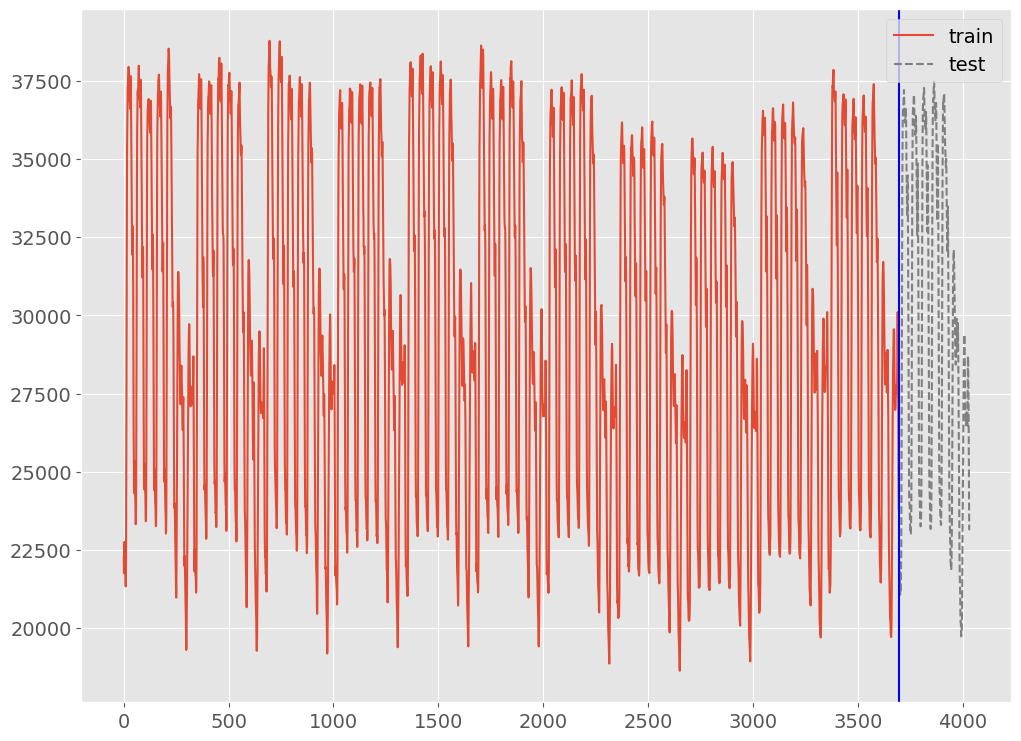

In [5]:
# グラフ（学習データとテストデータ）
fig, ax = plt.subplots()

# 学習データの描写
ax.plot(
    train.index, 
    train.values, 
    linestyle='-',
    label='train')

# テストデータの描写
ax.plot(
    test.index, 
    test.values, 
    linestyle='--',
    label='test', 
    color='gray')

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    len(train),
    color='blue')

# 凡例表示
ax.legend()

plt.show()


### 学習と予測

In [7]:
# モデルのインスタンス生成
model = TBATS(seasonal_periods=(48, 336))

# 学習
fitted_model = model.fit(train)


# 予測の実施
# 学習データ期間の予測値
train_pred = fitted_model.y_hat

# テストデータ期間の予測値
test_pred = fitted_model.forecast(steps=336)


/Users/marumarukun/Documents/my_study/Pythonによる時系列分析/.venv/lib/python3.9/site-packages/tbats/transformation/BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/Users/marumarukun/Documents/my_study/Pythonによる時系列分析/.venv/lib/python3.9/site-packages/tbats/transformation/BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/Users/marumarukun/Documents/my_study/Pythonによる時系列分析/.venv/lib/python3.9/site-packages/tbats/transformation/BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/Users/marumarukun/Documents/my_study/Pythonによる時系列分析/.venv/lib/python3.9/site-packages/tbats/transformation/BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/Users/marumarukun/Documents/my_study/Pythonによる時系列分析/.venv/lib/python3.9/site-packages/tbats/transformation/BoxCox.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/Users/marumarukun/Documents/my_study/Pythonによる時系列分析/.venv/lib/python3.9/si

In [8]:
# 予測モデルのテスト（テストデータ利用）
print('RMSE:\n',
      np.sqrt(mean_squared_error(
          test.x, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          test.x, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          test, test_pred))


RMSE:
 1351.3372900398474
MAE:
 1128.0479419708408
MAPE:
 0.03982684753517566


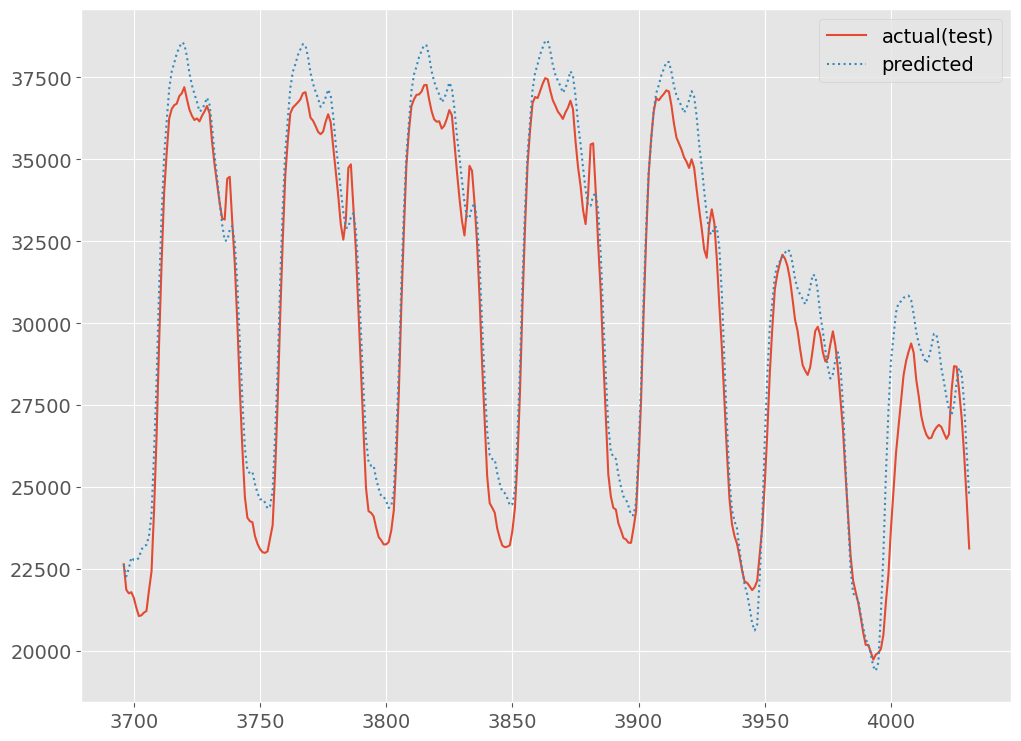

In [9]:
# グラフ(テストデータのみ描画)
fig, ax = plt.subplots()

ax.plot(
    test.index,
    test.x,
    linestyle='-',
    label='actual(test)'
)

ax.plot(
    test.index,
    test_pred,
    linestyle=':',
    label='predicted'
)

ax.legend()
plt.show()


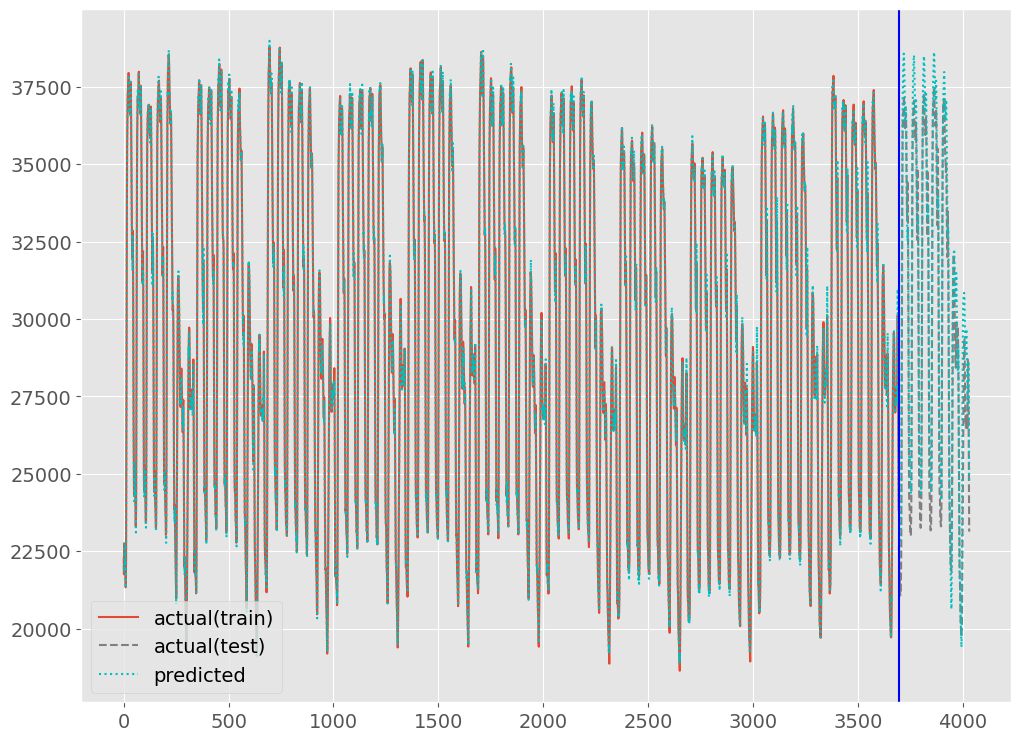

In [10]:
# グラフ（予測値と実測値）
fig, ax = plt.subplots()

# 学習データ
ax.plot(
    train.index,
    train.x,
    linestyle='-',
    label='actual(train)')

# テストデータ
ax.plot(
    test.index,
    test.x, 
    linestyle='--',
    label='actual(test)',
    color='gray')

# 学習データ
ax.plot(
    train.index,
    train_pred, 
    linestyle=':',
    color='c')

# テストデータ
ax.plot(
    test.index, 
    test_pred,
    linestyle=':',
    label="predicted", 
    color='c') 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    len(train),
    color='blue')

# 凡例表示
ax.legend()

plt.show()


## 3.4.3 ARIMAXで構築する予測モデル

### 準備

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ


In [2]:
dataset = sm.datasets.get_rdataset(
    "taylor", "forecast")

print(dataset.data) #確認


          x
0     22262
1     21756
2     22247
3     22759
4     22549
...     ...
4027  27946
4028  27133
4029  25996
4030  24610
4031  23132

[4032 rows x 1 columns]


In [3]:
# 説明変数X（Fourier terms）の生成

X = pd.DataFrame()
X.index = dataset.data.index

# Fourier termsの生成関数
def generate_fourier_terms(seasonal_periods, n_terms):
    """
    Generate Fourier terms for seasonal decomposition.
    
    Args:
        seasonal_periods (int): Number of seasonal periods.
        n_terms (int): Number of Fourier terms to generate.
        
    Returns:
        None
    """
    for num in range(1, n_terms+1):
        sin_col_name = f'sin{str(seasonal_periods)}_{str(num)}'
        cos_col_name = f'cos{str(seasonal_periods)}_{str(num)}'
        
        X[sin_col_name] = np.sin(2 * np.pi * num * X.index / seasonal_periods)
        X[cos_col_name] = np.cos(2 * np.pi * num * X.index / seasonal_periods)

# Fourier termsの生成
generate_fourier_terms(336, 10)
generate_fourier_terms(48, 10)

X


,sin336_1,cos336_1,sin336_2,cos336_2,sin336_3,cos336_3,sin336_4,cos336_4,sin336_5,cos336_5,...,sin48_6,cos48_6,sin48_7,cos48_7,sin48_8,cos48_8,sin48_9,cos48_9,sin48_10,cos48_10
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000,1.000000e+00,0.000000,1.000000
1,0.018699,0.999825,0.037391,0.999301,0.056070,0.998427,0.074730,0.997204,0.093364,0.995632,...,7.071068e-01,7.071068e-01,0.793353,0.608761,8.660254e-01,0.5,0.923880,3.826834e-01,0.965926,0.258819
2,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,...,1.000000e+00,6.123234e-17,0.965926,-0.258819,8.660254e-01,-0.5,0.707107,-7.071068e-01,0.500000,-0.866025
3,0.056070,0.998427,0.111964,0.993712,0.167506,0.985871,0.222521,0.974928,0.276836,0.960917,...,7.071068e-01,-7.071068e-01,0.382683,-0.923880,1.224647e-16,-1.0,-0.382683,-9.238795e-01,-0.707107,-0.707107
4,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,...,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,-8.660254e-01,-0.5,-1.000000,-1.836970e-16,-0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,-0.093364,0.995632,-0.185912,0.982566,-0.276836,0.960917,-0.365341,0.930874,-0.450655,0.892698,...,7.071068e-01,-7.071068e-01,0.991445,-0.130526,8.660254e-01,0.5,0.382683,9.238795e-01,-0.258819,0.965926
4028,-0.074730,0.997204,-0.149042,0.988831,-0.222521,0.974928,-0.294755,0.955573,-0.365341,0.930874,...,2.831940e-13,-1.000000e+00,0.500000,-0.866025,8.660254e-01,-0.5,1.000000,4.247911e-13,0.866025,0.500000
4029,-0.056070,0.998427,-0.111964,0.993712,-0.167506,0.985871,-0.222521,0.974928,-0.276836,0.960917,...,-7.071068e-01,-7.071068e-01,-0.382683,-0.923880,2.674988e-13,-1.0,0.382683,-9.238795e-01,0.707107,-0.707107
4030,-0.037391,0.999301,-0.074730,0.997204,-0.111964,0.993712,-0.149042,0.988831,-0.185912,0.982566,...,-1.000000e+00,-5.728014e-13,-0.965926,-0.258819,-8.660254e-01,-0.5,-0.707107,-7.071068e-01,-0.500000,-0.866025


In [4]:
# データの分割
y_train, y_test = train_test_split(
    dataset.data, test_size=336
)

X_train, X_test = train_test_split(
    X, test_size=336
)


### 学習と予測

In [5]:
# 予測モデルの構築と学習
arima_fourier_model = auto_arima(
    y=y_train,
    X=X_train, # Xは大文字なの注意
    seasonal=False,
    maxiter=10
)


In [6]:
# 予測

# 学習データ期間の予測値
train_pred = arima_fourier_model.predict_in_sample(X=X_train)

# テストデータ期間の予測値
test_pred = arima_fourier_model.predict(n_periods=336, X=X_test)


In [7]:
# 評価
print('RMSE:\n',
      np.sqrt(mean_squared_error(
          y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          y_test, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          y_test, test_pred))


RMSE:
 880.5707603848175
MAE:
 639.2967362468446
MAPE:
 0.02196876369394963


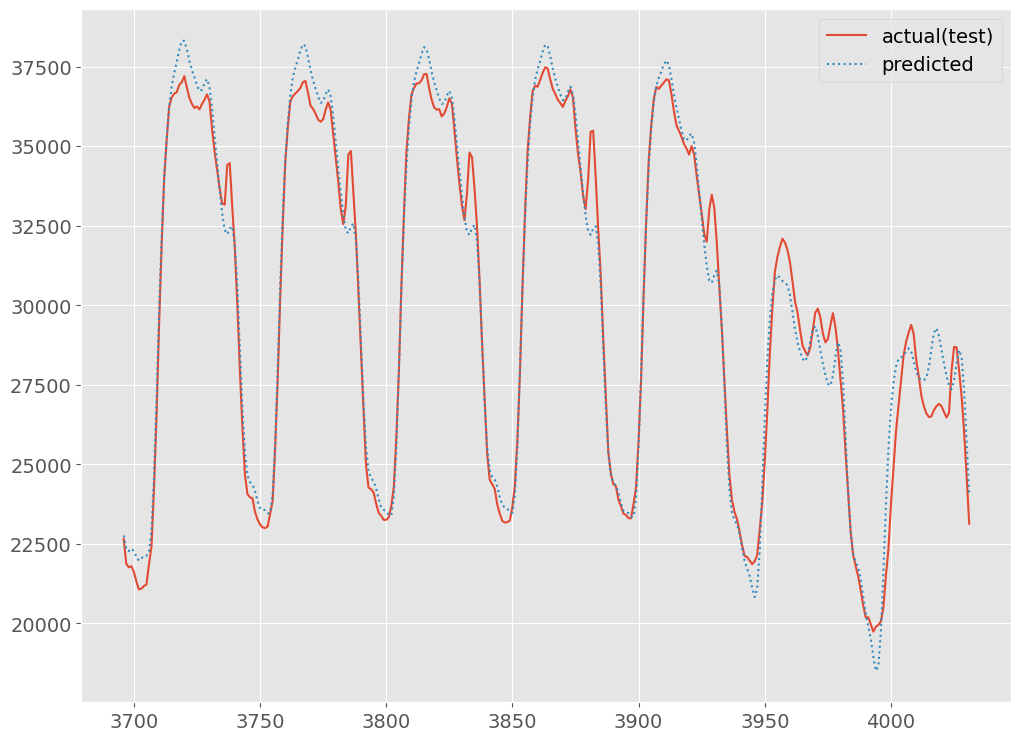

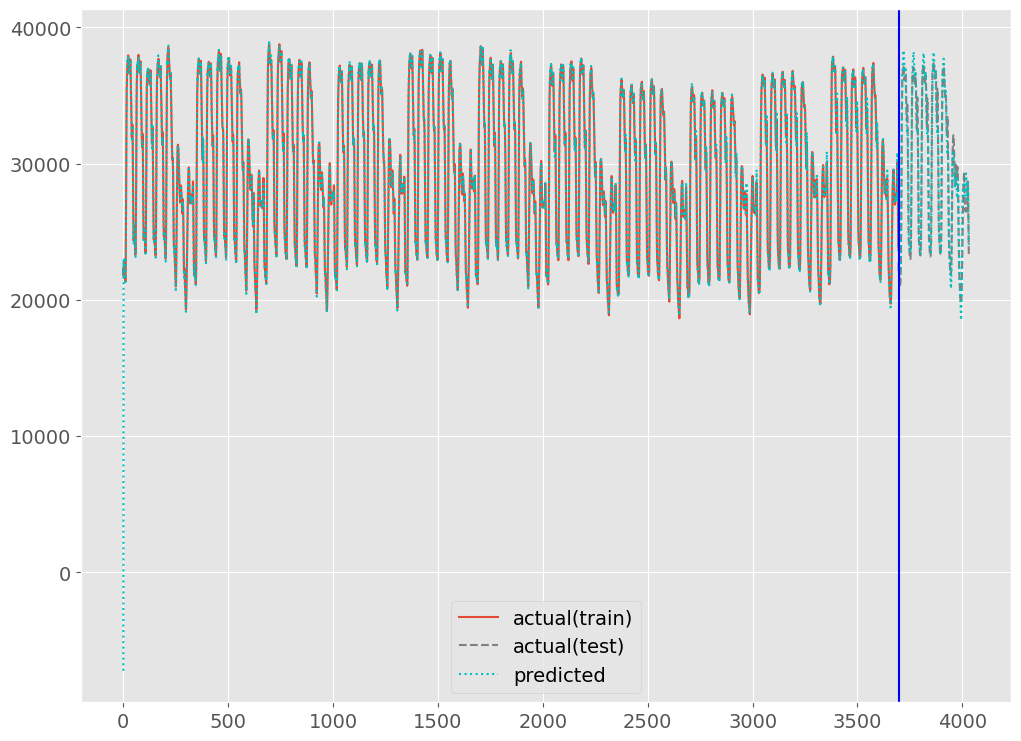

In [8]:
fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index,
    test_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()


# In[9]:


#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    y_train.index, 
    y_train.values,
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    y_test.index,
    y_test.values, 
    linestyle='--',
    label='actual(test)', 
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    y_train.index,
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    y_test.index, 
    test_pred,
    linestyle=':',
    label="predicted",
    color='c') 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    len(y_train),
    color='blue')

# 凡例表示
ax.legend()

plt.show()
